# Econometrics - Statsmodels

- Regression analysis on python is based on two libraries : statsmodels, linearmodels
    - (1) statsmodels : [statsmodels](https://www.statsmodels.org/stable/index.html)
        - Cross-sectional models, time-series models
    - (2) Linearmodels : [linearmodels](https://pypi.org/project/linearmodels/)
        - Panel, Instrumental Variable, Asset Pricing, and System Regression models

<img src="./img/1.png">

statsmodels.tsa.api : 시계열모형 추론 혹은 방법.

##### Research Problem : 
- Asset pricing models only care about systematic risk and claim that risk premia is the only determinant of asset returns. 
- Conversely, in other words they have nothing to say about individual returns : 각 개별적인 주식수익률은 신경쓰지 않도록 한다.
- Let's assume that we want to explain individual returns.
- People say that asset prices increase when someone buys the asset, and vice versa : 자산을 살때 가격이 오르고, 팔때 가격이 떨어진다는 것을 검증
    - Are asset returns related with demand pressure? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('data/005930.txt', index_col=0, parse_dates=True)
#df는 1분단위로 기록한 삼성전자의 가격변동, 시장가 주문 거래로 기록한것, 실제 거래 데이터
cols = df.columns
df['date'] = df.index.date
# index는 timestamp이다
df = df.loc[(df.date == df.date.shift()) | (df.date ==df.date.shift(-1)), ][cols]
df.head()

,open,high,low,close,volume,sell,buy,kospi
date,,,,,,,,
2017-04-24 09:02:00,41200,41200,41180,41200,41700,12700.0,29000.0,2176.090088
2017-04-24 09:03:00,41200,41220,41180,41200,21750,5250.0,16500.0,2176.260010
2017-04-24 09:04:00,41200,41220,41200,41200,25450,6900.0,18550.0,2176.260010
2017-04-24 09:05:00,41200,41200,41140,41140,15350,7850.0,7500.0,2175.459961
2017-04-24 09:06:00,41140,41180,41140,41160,16450,6100.0,10350.0,2174.350098


sell : 시장가 매도
buy : 시장가 매수
kospi : 코스피 지수
volume : 거래량

- kospi는 market portfolio를 대용할만한 Index이다
- 위 데이터는 High Frequency Data이다
- High Frequency 데이터를 다룰 때는, 고빈도 데이터에서만 나타나는 White noise가 존재하기 때문에 실질적인 데이터분석에서는 30분 단위의 데이터가 가장 많이 사용된다

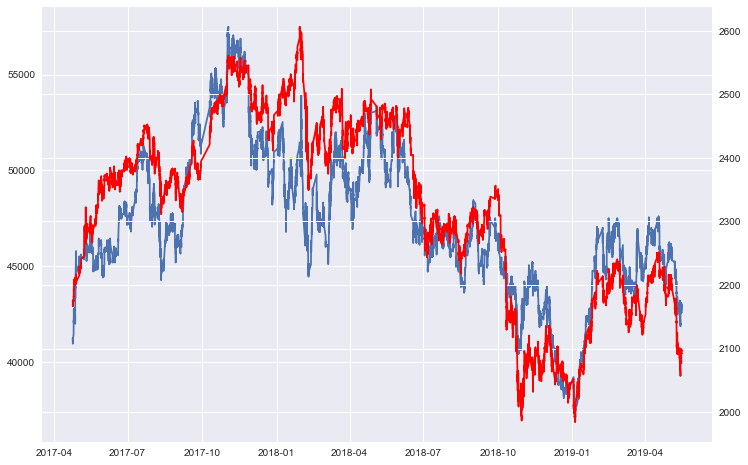

In [10]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.plot(df.close)
ax2.plot(df.kospi, 'r')
plt.show()

Kospi는 모든 상장회사들의 가치를 합친것으로, 삼성전자의 비중이 굉장히 높아 추세가 굉장히 유사하게 흘러간다

- 파란색은 삼성전자 주가의 종가, 빨간색은 kospi지수의 종가이다

In [4]:
# resample to 20m - 20분 단위로 치환, 시장미시적 노이즈를 줄이기 위해 다운샘플링, 과적합 방지

df_20 = pd.DataFrame()
#resample method를 이용해 high frequency를 low frequency로 바꿀 수 있다.
df_20['open'] = df.open.resample('20t').first()
df_20['high'] = df.high.resample('20t').max()
df_20['low'] = df.low.resample('20t').min()
df_20['close'] = df.close.resample('20t').last()
df_20

,open,high,low,close
date,,,,
2017-04-24 09:00:00,41200.0,41220.0,41020.0,41080.0
2017-04-24 09:20:00,41100.0,41100.0,41020.0,41060.0
2017-04-24 09:40:00,41060.0,41260.0,41040.0,41220.0
2017-04-24 10:00:00,41240.0,41240.0,41160.0,41160.0
2017-04-24 10:20:00,41180.0,41180.0,41060.0,41080.0
...,...,...,...,...
2019-05-15 14:00:00,42900.0,42950.0,42850.0,42850.0
2019-05-15 14:20:00,42850.0,42900.0,42800.0,42850.0
2019-05-15 14:40:00,42800.0,42900.0,42800.0,42800.0


In [5]:
df.open.resample('20m').first() # 20개월 단위로 샘플링 (예제)
# first() method를 통해 interval data의 맨 앞 데이터를 추출한다.

date
2017-04-30    41200
2018-12-31    45140
2020-08-31    39050
Freq: 20M, Name: open, dtype: int64

In [6]:
def mindata(df,h) : 
    
    temp = pd.DataFrame()
    temp['open'] = df.open.resample(h).first().dropna()
    temp['high'] = df.high.resample(h).max()
    temp['low'] = df.low.resample(h).min()
    temp['close'] = df.close.resample(h).last()
    temp['volume'] = df.volume.resample(h).sum()
    temp['buy'] = df.buy.resample(h).sum()
    temp['sell'] = df.sell.resample(h).sum()
    temp['kospi'] = df.kospi.resample(h).last()
    
    return temp

df_20 = mindata(df,'20t')

In [7]:
df_20

,open,high,low,close,volume,buy,sell,kospi
date,,,,,,,,
2017-04-24 09:00:00,41200.0,41220.0,41020.0,41080.0,399100,222300.0,176800.0,2174.939941
2017-04-24 09:20:00,41100.0,41100.0,41020.0,41060.0,370150,150050.0,220100.0,2172.189941
2017-04-24 09:40:00,41060.0,41260.0,41040.0,41220.0,566700,431150.0,135550.0,2174.409912
2017-04-24 10:00:00,41240.0,41240.0,41160.0,41160.0,501700,225550.0,276150.0,2172.889893
2017-04-24 10:20:00,41180.0,41180.0,41060.0,41080.0,242950,123050.0,119900.0,2169.459961
...,...,...,...,...,...,...,...,...
2019-05-15 14:00:00,42900.0,42950.0,42850.0,42850.0,209119,79810.0,129309.0,2093.709961
2019-05-15 14:20:00,42850.0,42900.0,42800.0,42850.0,225300,71416.0,153884.0,2093.469971
2019-05-15 14:40:00,42800.0,42900.0,42800.0,42800.0,284886,157144.0,127742.0,2094.699951


In [8]:
df_20['ret'] = df_20.close.pct_change()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ret', ylabel='Density'>

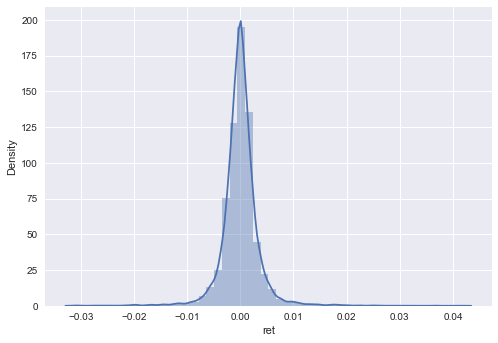

In [11]:
# compute returns

df_20['ret'] = df_20.close.pct_change()
sns.distplot(df_20.ret)

In [12]:
print(df_20.ret.mean())
print(df_20.ret.std())
print(df_20.ret.skew()) # 3차 적률, 왜도, 한쪽으로 얼마나 쏠려있는지를 확인
print(df_20.ret.kurtosis()) # 4차 적률, 첨도, 얼마나 중심으로 몰려 있는지를 확인
print(df_20.ret.autocorr()) 

9.97348505534206e-06
0.003588090737379132
0.21745939141146095
16.37912382375123
-0.037096347114591574


금융데이터는 보통 평균에 데이터가 많이 몰려 첨도가 매우 높게 나타나는 경향이 있다.
- 오차는 평균이 0, 분산이 시그마 제곱인 정규분포를 따른다.
- rule of thumb : 엄지의 법칙 (2의 법칙, t값이 2보다 크면 괜찮다는 근사치 값) -> 사회과학에서 관행적으로 용인이 됨

**수익률의 자기상관**

- 상관계수는 두 가지 변수가 있을 때, 이 변수들간에 얼마나 같이 움직이는지를 보여주는 계수이다.
- 자기상관계수는 두 시점간의 상관성이 얼마나 되는지 보여준다.
- 자기상관계수가 높으면 가우스 - 마르코프 이론이 들어맞지 않을수도 있다.

In [14]:
# What independent variables should we use? 

# (1) Kospi return 

df_20['kospi_ret'] = df_20.kospi.pct_change()

# (2) Order flow(주문 흐름) : market buy order - market sell order

df_20['of'] = df_20.buy - df_20.sell

# (3) Volatility : 변동성

df_20['volatility']  = df_20['ret']**2

주가의 수익률 -> 종속변수

Order flow : order pressure -> 매수세와 매도세를 확인할 수 있다.

In [15]:
df_20

,open,high,low,close,volume,buy,sell,kospi,ret,kospi_ret,of,volatility
date,,,,,,,,,,,,
2017-04-24 09:00:00,41200.0,41220.0,41020.0,41080.0,399100,222300.0,176800.0,2174.939941,NaN,NaN,45500.0,NaN
2017-04-24 09:20:00,41100.0,41100.0,41020.0,41060.0,370150,150050.0,220100.0,2172.189941,-0.000487,-0.001264,-70050.0,2.370277e-07
2017-04-24 09:40:00,41060.0,41260.0,41040.0,41220.0,566700,431150.0,135550.0,2174.409912,0.003897,0.001022,295600.0,1.518456e-05
2017-04-24 10:00:00,41240.0,41240.0,41160.0,41160.0,501700,225550.0,276150.0,2172.889893,-0.001456,-0.000699,-50600.0,2.118783e-06
2017-04-24 10:20:00,41180.0,41180.0,41060.0,41080.0,242950,123050.0,119900.0,2169.459961,-0.001944,-0.001579,3150.0,3.777715e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-15 14:00:00,42900.0,42950.0,42850.0,42850.0,209119,79810.0,129309.0,2093.709961,-0.002328,-0.000277,-49499.0,5.420928e-06
2019-05-15 14:20:00,42850.0,42900.0,42800.0,42850.0,225300,71416.0,153884.0,2093.469971,0.000000,-0.000115,-82468.0,0.000000e+00
2019-05-15 14:40:00,42800.0,42900.0,42800.0,42800.0,284886,157144.0,127742.0,2094.699951,-0.001167,0.000588,29402.0,1.361565e-06


In [17]:
df_20.date.shift()

date
2017-04-24 09:00:00           NaN
2017-04-24 09:20:00    2017-04-24
2017-04-24 09:40:00    2017-04-24
2017-04-24 10:00:00    2017-04-24
2017-04-24 10:20:00    2017-04-24
                          ...    
2019-05-15 14:00:00    2019-05-15
2019-05-15 14:20:00    2019-05-15
2019-05-15 14:40:00    2019-05-15
2019-05-15 15:00:00    2019-05-15
2019-05-15 15:20:00    2019-05-15
Name: date, Length: 9934, dtype: object

In [16]:
# Additional issue - overnight returns

df_20['date'] = df_20.index.date
df_20['overnight'] = 0
df_20.loc[df_20.date!=df_20.date.shift(), 'overnight'] = df_20.loc[df_20.date!=df_20.date.shift(), 'ret']
df_20.overnight[df_20.overnight!=0]

date
2017-04-24 09:00:00         NaN
2017-04-25 09:00:00    0.014549
2017-04-26 09:00:00    0.000468
2017-04-27 09:00:00    0.002804
2017-04-28 09:00:00    0.030109
                         ...   
2019-05-08 09:00:00   -0.012263
2019-05-09 09:00:00   -0.004520
2019-05-10 09:00:00    0.008245
2019-05-13 09:00:00   -0.009324
2019-05-14 09:00:00   -0.011723
Name: overnight, Length: 483, dtype: float64

In [18]:
df_20

,open,high,low,close,volume,buy,sell,kospi,ret,kospi_ret,of,volatility,date,overnight
date,,,,,,,,,,,,,,
2017-04-24 09:00:00,41200.0,41220.0,41020.0,41080.0,399100,222300.0,176800.0,2174.939941,NaN,NaN,45500.0,NaN,2017-04-24,NaN
2017-04-24 09:20:00,41100.0,41100.0,41020.0,41060.0,370150,150050.0,220100.0,2172.189941,-0.000487,-0.001264,-70050.0,2.370277e-07,2017-04-24,0.0
2017-04-24 09:40:00,41060.0,41260.0,41040.0,41220.0,566700,431150.0,135550.0,2174.409912,0.003897,0.001022,295600.0,1.518456e-05,2017-04-24,0.0
2017-04-24 10:00:00,41240.0,41240.0,41160.0,41160.0,501700,225550.0,276150.0,2172.889893,-0.001456,-0.000699,-50600.0,2.118783e-06,2017-04-24,0.0
2017-04-24 10:20:00,41180.0,41180.0,41060.0,41080.0,242950,123050.0,119900.0,2169.459961,-0.001944,-0.001579,3150.0,3.777715e-06,2017-04-24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-15 14:00:00,42900.0,42950.0,42850.0,42850.0,209119,79810.0,129309.0,2093.709961,-0.002328,-0.000277,-49499.0,5.420928e-06,2019-05-15,0.0
2019-05-15 14:20:00,42850.0,42900.0,42800.0,42850.0,225300,71416.0,153884.0,2093.469971,0.000000,-0.000115,-82468.0,0.000000e+00,2019-05-15,0.0
2019-05-15 14:40:00,42800.0,42900.0,42800.0,42800.0,284886,157144.0,127742.0,2094.699951,-0.001167,0.000588,29402.0,1.361565e-06,2019-05-15,0.0


$y = X\beta + \epsilon$
- we assume that y : Series, X : DataFrame

In [18]:
test1 = df_20.dropna()
y = (test1.ret - test1.overnight) * 100
X = np.log(test1[['volatility', 'volume']]+1)
X['of'] = test1.of
X['kospi_ret'] = test1.kospi_ret * 100
X

,volatility,volume,of,kospi_ret
date,,,,
2017-04-24 09:20:00,2.370277e-07,12.821666,-70050.0,-0.126440
2017-04-24 09:40:00,1.518444e-05,13.247587,295600.0,0.102200
2017-04-24 10:00:00,2.118781e-06,13.125760,-50600.0,-0.069905
2017-04-24 10:20:00,3.777708e-06,12.400615,3150.0,-0.157851
2017-04-24 10:40:00,2.133247e-06,12.516681,19350.0,-0.102790
...,...,...,...,...
2019-05-15 14:00:00,5.420914e-06,12.250664,-49499.0,-0.027698
2019-05-15 14:20:00,0.000000e+00,12.325193,-82468.0,-0.011462
2019-05-15 14:40:00,1.361564e-06,12.559848,29402.0,0.058753


In [19]:
test1 = df_20.dropna()
y = test1.ret
X = test1[['volatility', 'volume', 'of', 'kospi_ret']]

In [20]:
import statsmodels.api as sm

In [24]:
X = sm.add_constant(X) # intercet 추가
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     2578.
Date:                Sat, 14 May 2022   Prob (F-statistic):               0.00
Time:                        03:36:46   Log-Likelihood:                 45368.
No. Observations:                9933   AIC:                        -9.073e+04
Df Residuals:                    9928   BIC:                        -9.069e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   4.12e-05      6.450      0.000       0.000       0.000
volatility     7.5948      0.518     14.667      0.000       6.580       8.610
volume     -7.777e-10   6.96e-11    -11.178      0.000   -9.14e-10   -6.41e-10
of          1.228e-09    7.3e-11     16.806      0.000    1.08e-09    1.37e-09
kospi_ret      1.3950      0.015     95.311      0.000       1.366       1.424
==============================================================================
Omnibus:                     2423.807   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           132024.869
Skew:                          -0.262   Prob(JB):                         0.00
Kurtosis:                      20.853   Cond. No.                     1.77e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
X.corr() # 상수는 전부 결측치이다

,const,volatility,volume,of,kospi_ret
const,NaN,NaN,NaN,NaN,NaN
volatility,NaN,1.000000,0.366010,0.035917,-0.038205
volume,NaN,0.366010,1.000000,0.684421,-0.006134
of,NaN,0.035917,0.684421,1.000000,0.126601
kospi_ret,NaN,-0.038205,-0.006134,0.126601,1.000000


In [20]:
import statsmodels.api as sm

# set X and y
test1 = df_20.dropna()

y = (test1.ret - test1.overnight) * 100
X = np.log(test1[['volatility', 'volume']]+1)
X['of'] = test1.of
X['kospi_ret'] = test1.kospi_ret * 100
X = sm.add_constant(X)
X.corr()

,const,volatility,volume,of,kospi_ret
const,NaN,NaN,NaN,NaN,NaN
volatility,NaN,1.000000,0.323538,0.035923,-0.038217
volume,NaN,0.323538,1.000000,0.355214,-0.002918
of,NaN,0.035923,0.355214,1.000000,0.126601
kospi_ret,NaN,-0.038217,-0.002918,0.126601,1.000000


correlation을 확인하는 이유는, 다중공선성 문제가 있는지 확인하기 위해서이다. 보통 다중공선성이 있다면 두 변수간 상관계수가 높게 나타난다.
- y = 2 + 3X 모형이 있을 때, 변수들간의 관계가 높게 나타나면 모형의 제대로된 변수의 추정이 되지 않을 수 있다.

- $ y_i = \beta_0 + \beta_1 X_i + \epsilon_i$ 
- $ y_i = \beta_0 + \beta_1 \log{X_i} + \epsilon_i$ 

In [22]:
import statsmodels.api as sm

ols = sm.OLS(y,X)

In [26]:
import statsmodels.api as sm

ols = sm.OLS(y,X)
res = ols.fit() # fit() method : 학습을 시켜줌
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     2578.
Date:                Sat, 14 May 2022   Prob (F-statistic):               0.00
Time:                        03:46:26   Log-Likelihood:                 45368.
No. Observations:                9933   AIC:                        -9.073e+04
Df Residuals:                    9928   BIC:                        -9.069e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   4.12e-05      6.450      0.000       0.000       0.000
volatility     7.5948      0.518     14.667      0.000       6.580       8.610
volume     -7.777e-10   6.96e-11    -11.178      0.000   -9.14e-10   -6.41e-10
of          1.228e-09    7.3e-11     16.806      0.000    1.08e-09    1.37e-09
kospi_ret      1.3950      0.015     95.311      0.000       1.366       1.424
==============================================================================
Omnibus:                     2423.807   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           132024.869
Skew:                          -0.262   Prob(JB):                         0.00
Kurtosis:                      20.853   Cond. No.                     1.77e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

-2.837335592623895e-10
0.0025130612215840424
-0.26202893817774486
17.862392579454273
-0.053619974991125294


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


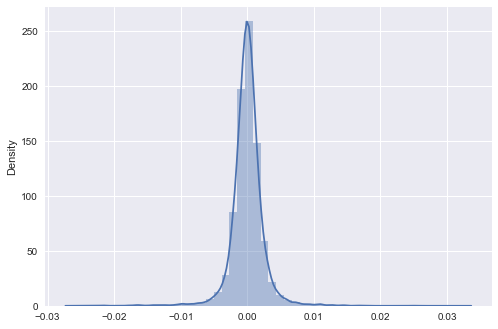

In [28]:
sns.distplot(res.resid)
print(res.resid.mean())
print(res.resid.std())
print(res.resid.skew())
print(res.resid.kurtosis())
print(res.resid.autocorr())
# 오차항에 자기상관성이 강하면 OLS모형이 잘못되었다는 것이다

In [ ]:
import statsmodels.api as sm

ols = sm.OLS(y,X)
res = ols.fit()
res.summary()

In [25]:
test2.columns

Index(['open', 'high', 'low', 'close', 'volume', 'buy', 'sell', 'kospi',
       'date', 'overnight', 'ret', 'kospi_ret', 'of', 'volatility', 'y'],
      dtype='object')

In [29]:
import statsmodels.formula.api as smf
test2 = test1.copy()
test2['y'] = test2.ret - test1.overnight
mod = smf.ols(formula='y ~ kospi_ret + volatility + volume', data=test2).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     1008.
Date:                Fri, 05 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:39:40   Log-Likelihood:                 46567.
No. Observations:                9933   AIC:                        -9.313e+04
Df Residuals:                    9929   BIC:                        -9.310e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.353e-05   3.13e-05     -0.751      0.453    -8.5e-05    3.79e-05
kospi_ret      0.6968      0.013     54.580      0.000       0.672       0.722
volatility     3.6901      0.436      8.472      0.000       2.836       4.544
volume      -4.03e-11   4.24e-11     -0.952      0.341   -1.23e-10    4.27e-11
==============================================================================
Omnibus:                     1800.301   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42668.698
Skew:                           0.176   Prob(JB):                         0.00
Kurtosis:                      13.147   Cond. No.                     1.54e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.54e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

order flow의 변수가 빠지면 설명력이 떨어진다.